First do an Earthquake simulation 

In [1]:
%cd Simple1DOF

/home/tomsimpson/Documents/ETHwork/DynSub/Simple1DOF


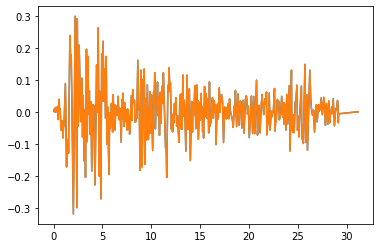

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.io import loadmat
from math import sqrt


os.getcwd()
Ag = loadmat('ElCentro.mat')
Ag = Ag['Ag']

plt.plot(Ag[:,0],Ag[:,1])

#Ag[:,1] = 0.75*Ag[:,1]
plt.plot(Ag[:,0], Ag[:,1])


In [76]:
def f(y, t, params):
    y1, y2, y3, y4 = y
    k, c, m, knl, knl2, Ag, ts = params
    i = int(t/ts)
    ag=Ag[i,1]
    derivs=[y2,
           (-m*ag*9.81-knl*y1**3-2*k*y1+k*y3-2*c*y2+c*y4)/m, y4, (-k*(y3-y1)-c*(y4-y2))/m]
    return derivs

tStop = 31.2
ts = 0.02
t = np.arange(0., tStop, ts)
nt = len(t)


np.random.seed(1)
#Parameters
k = (176.75+1224.1)*1e6
m = 1.75e6
c = 0.04*sqrt(k*m)
knl = 10e12

#knl2 = 10e10
knl2 = 0
#knl=0
params=[k, c, m, knl, knl2, Ag, ts]

#Initial values
y1_0=0
y2_0=0
y3_0=0
y4_0=0
y0 = [y1_0, y2_0, y3_0, y4_0]

psoln = odeint(f, y0, t, args=(params,))

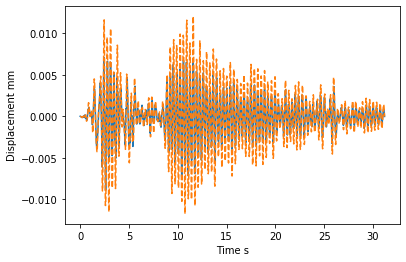

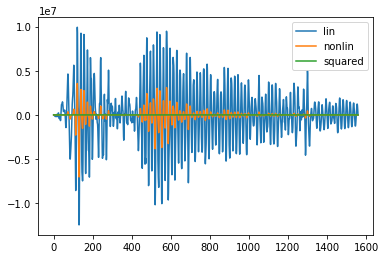

In [77]:
plt.figure(0)
plt.plot(Ag[:,0],psoln[:,0])
plt.plot(Ag[:,0], psoln[:,2],'--')
plt.xlabel('Time s')
plt.ylabel('Displacement mm')

plt.figure(1)
plt.plot(k*psoln[:,0],label='lin')
plt.plot(knl*psoln[:,0]**3,label='nonlin')
plt.plot(knl2*psoln[:,0]**2, label='squared')

plt.legend()

In [51]:
F_exp = -(psoln[:,0:1]**3)*10e12
ExInps = np.concatenate((Ag[:,1:],F_exp),axis=1)
X = psoln[:,0:1]


In [52]:
f_train = ExInps[0:1000,:]
f_test = ExInps[:,:]

x_train = X[0:1000,:]
x_test = X[:,:]

datasetTrain = np.concatenate((f_train,x_train),axis=1)
datasetTest=np.concatenate((f_test,x_test),axis=1)

def create_dataset(dataset, look_back=6):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), :]
        X.append(a)
        Y.append(dataset[i + look_back, 2:])
    return np.array(X), np.array(Y)

f_train, x_train = create_dataset(datasetTrain)
f_test, x_test = create_dataset(datasetTest)




(993, 6, 3)
1.1337927271810334e-07


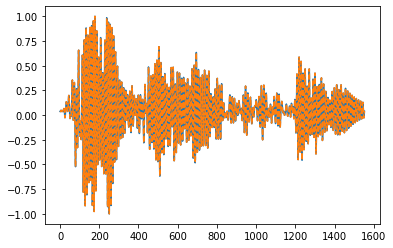

In [53]:
## One Step Ahead Prediction

print(f_train.shape)
f_train = np.reshape(f_train,(f_train.shape[0],-1))
f_test = np.reshape(f_test,(f_test.shape[0],-1))
fmax=f_test.max(axis=0,keepdims=True)
fmin=f_test.min(axis=0,keepdims=True)
f_test_norm=2*(f_test-fmin)/(fmax-fmin)-1


xmax=x_test.max(axis=0,keepdims=True)
xmin=x_test.min(axis=0,keepdims=True)
x_test_norm=2*(x_test-xmin)/(xmax-xmin)-1

f_train_norm = f_test_norm[:1000,:]
x_train_norm = x_test_norm[:1000,:]



dispmax = fmax[:,2]
dispmin = fmin[:,2]

forcemax = fmax[:,1]
forcemin = fmin[:,1]

params = [dispmax, dispmin, forcemax, forcemin]


from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(f_train_norm, x_train_norm)
#print(reg.score(f_train_norm,x_train_norm))
#print(reg.score(f_test_norm,x_test_norm))

yy = reg.predict(f_test_norm)

plt.plot(yy)
plt.plot(x_test_norm,'--')

from sklearn.metrics import mean_squared_error
print(mean_squared_error(yy,x_test_norm))

In [1]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.preprocessing import normalize
import keras




usualCallback = EarlyStopping(monitor='val_loss', min_delta=1e-10, patience = 150)
checkpoint = ModelCheckpoint('.mdl_wts_nl.hdf5', verbose=1, monitor='val_loss',save_best_only=True, mode='auto') 
callbacks_list = [usualCallback, checkpoint]

print(f_train.shape[1])

nn = Sequential()
nn.add(Dense(15,input_dim = f_train.shape[1], activation=''))
nn.add(Dense(1,activation='linear'))
opt = keras.optimizers.Adam(lr=0.0002)
nn.compile(loss='mean_squared_error', optimizer=opt)

nn.summary()

nn.load_weights('.mdl_wts_nl.hdf5')
nn.fit(f_train_norm,x_train_norm,validation_data=(f_test_norm,x_test_norm) ,epochs=2000, batch_size=64, callbacks=callbacks_list,shuffle=False)

nn.load_weights('.mdl_wts_nl.hdf5')
print(nn.evaluate(f_test_norm,x_test_norm))

yhat = nn.predict(f_test_norm)
plt.plot(yhat)
plt.plot(x_test_norm,'--')

print(mean_squared_error(yhat,x_test_norm))

Using TensorFlow backend.


NameError: name 'f_train' is not defined

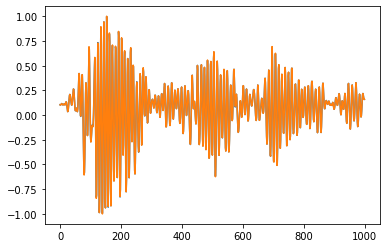

In [47]:
%matplotlib inline
import mpld3
mpld3.enable_notebook()
yhat = nn.predict(f_train_norm)
plt.plot(yhat)
plt.plot(x_train_norm)

(1500, 18)
(1553, 18)
0.021469563554012146


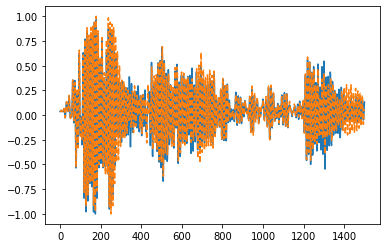

In [67]:
### Simulation with "Hybrid Test" i.e. at each time point the input given is the AR input + ground acceleration
### along with the exogenous forcing which is calculated from the "Physical System"

%matplotlib inline
import mpld3
mpld3.enable_notebook()


'''
def sim_pred(mdl, AG, X0, steps):
    Xhat = X0
    y = []
    Xstore = []
    for i in range(steps):
        #print(Xhat)
        Yhat = mdl.predict(Xhat)
        #RestForce = -Yhat*1224.1e6
        RestForce  = -Yhat
        #print(Yhat)
        y.append(Yhat)
        Xstore.append(Xhat)
        Xhat = Xhat[:,-3:]
        Xhat = np.concatenate((Xhat,AG[i+2:i+3,0:]),axis=1)
        Xhat = np.concatenate((Xhat,RestForce),axis=1)
        Xhat = np.concatenate((Xhat,Yhat),axis=1)   
        #print(Xhat.shape)
    
    
    return(y, Xstore)
'''

def sim_pred(mdl, AG, X0, steps, params):
    Xhat = X0
    y = []
    Xstore = []
    dispmax, dispmin, forcemax, forcemin = params
    for i in range(steps):
        #print(Xhat)
        Yhat = mdl.predict(Xhat)
        #RestForce = -Yhat*1224.1e6
        #RestForce  = -Yhat**3
        y_un = dispmin + (-Yhat+1)*(dispmax-dispmin)/2
        RestForce_un = (y_un**3)*10e12
        RestForce = 2*(RestForce_un-forcemin)/(forcemax-forcemin)-1
        #print(Yhat)
        y.append(Yhat)
        Xstore.append(Xhat)
        Xhat = Xhat[:,-15:]
        Xhat = np.concatenate((Xhat,AG[i+6:i+7,0:]),axis=1)
        Xhat = np.concatenate((Xhat,RestForce),axis=1)
        Xhat = np.concatenate((Xhat,Yhat),axis=1)   
        #print(Xhat.shape)
    
    
    return(y, Xstore)
    

    
(y, Xstore)= sim_pred(nn, f_test_norm[:,0:1], f_train_norm[0:1,:], 1500, params)

Xstore = np.asarray(Xstore)
Xstore = np.squeeze(Xstore)
print(Xstore.shape)

print(f_test.shape)
'''
plt.plot(Xstore[:,1])
plt.plot(f_test_norm[:,1])
'''



y = np.asarray(np.squeeze(y))
plt.plot(y[:])
plt.plot(x_test_norm[:1498],'--')


print(mean_squared_error(y[:],x_test_norm[:y.shape[0]]))

#nn.save_weights('notbad.hdf5')



In [47]:
X0 = f_test_norm[0:1,:]
Yhat1 = nn.predict(X0)
Y1 = x_test_norm[0]


yy=[]

y_un = dispmin + (Yhat1+1)*(dispmax-dispmin)/2
RestForce_un = (y_un**3)*10e12
RestForce = 2*(RestForce_un-forcemin)/(forcemax-forcemin)-1
#print(Yhat)
yy.append(Yhat1)
i=0

Xhat1 = X0[:,-15:]
Xhat1 = np.concatenate((Xhat1,f_test_norm[i+6:i+7,0:1]),axis=1)
Xhat1 = np.concatenate((Xhat1,RestForce),axis=1)
Xhat1 = np.concatenate((Xhat1,Yhat1),axis=1)   


X1 = f_test_norm[1:2,:]

np.set_printoptions(suppress=True)


Yhat2 = nn.predict(Xhat1)
Y2 = x_test_norm[1]

print(Yhat2)
print(Y2)


y_un = dispmin + (Yhat2+1)*(dispmax-dispmin)/2
RestForce_un = (y_un**3)*10e12
RestForce = 2*(RestForce_un-forcemin)/(forcemax-forcemin)-1
#print(Yhat)
yy.append(Yhat2)
i=1

Xhat2 = Xhat1[:,-15:]
Xhat2 = np.concatenate((Xhat2,f_test_norm[i+6:i+7,0:1]),axis=1)
Xhat2 = np.concatenate((Xhat2,RestForce),axis=1)
Xhat2 = np.concatenate((Xhat2,Yhat2),axis=1)   



Yhat3 = nn.predict(Xhat2)
y_un = dispmin + (Yhat3+1)*(dispmax-dispmin)/2
RestForce_un = (y_un**3)*10e12
RestForce = 2*(RestForce_un-forcemin)/(forcemax-forcemin)-1
#print(Yhat)
yy.append(Yhat3)
i=2

Xhat3 = Xhat2[:,-15:]
Xhat3 = np.concatenate((Xhat3,f_test_norm[i+6:i+7,0:1]),axis=1)
Xhat3 = np.concatenate((Xhat3,RestForce),axis=1)
Xhat3 = np.concatenate((Xhat3,Yhat2),axis=1)   

print(Xhat3)
print(f_test_norm[3:4,:])

[[0.03606437]]
[0.03531484]
[[ 0.04696943 -0.13996696  0.0413059   0.05766271 -0.13996682  0.04008241
   0.06832359 -0.13996663  0.0389513   0.05520001 -0.13996792  0.03769427
   0.04207644 -0.13996841  0.03606437  0.02895287 -0.13996837  0.03606437]]
[[ 0.04696943 -0.13996696  0.0413059   0.05766271 -0.13996682  0.04008241
   0.06832359 -0.13996663  0.0389513   0.05520001 -0.1399662   0.03712391
   0.04207644 -0.13996558  0.03531484  0.02895287 -0.13996565  0.03547679]]


In [12]:
X0 = f_train[0:1,:]
#print(X0)
#print(Xstore[0])
print(f_train[1:2,:])
print(Xstore[1])
print(Ag.shape)

[[ 3.64000000e-03  1.46206320e+04 -1.19439849e-05  9.90000000e-04
   4.73670625e+04 -3.86954191e-05]]
[[ 0.04489558  0.0420696  -0.0420696   0.03630855  0.04611788 -0.04611788]]
(1560, 2)


[[ 3.64000000e-03  1.46206320e+04 -1.19439849e-05  9.90000000e-04
   4.73670625e+04 -3.86954191e-05]]
[[ 3.64000000e-03  1.46206324e+04 -1.19439853e-05  9.90000000e-04
   1.89547200e+06 -1.54846173e-03]]
0.0
[[ 0.05351501  0.04055207 -0.04055207  0.04489558  0.0420711  -0.0420711 ]]


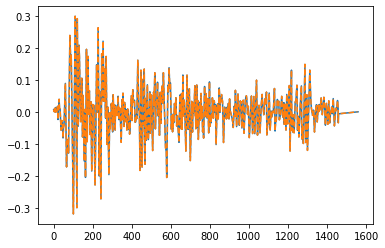

In [373]:
'''
X0 = f_train[0:1,:]
print(X0)
print(Xstore[0])
'''
print(f_train[1:2,:])
print(Xstore[1])

plt.plot(Ag[:,1])
#plt.plot(f_test[:,1])
plt.plot(f_test[:,0],'--')
print(mean_squared_error(f_test[:1000,0],Ag[:1000,1]))
print(f_train_norm[0:1,:])

In [22]:
X0 = f_train_norm[0:1,:]
yhat1 = nn.predict(X0)
print(yhat1)
print(x_train_norm[0])

X1 = f_train_norm[1:2,:]
print(X1)
X1hat = X1
X1hat[0,-1] = yhat1
X1hat[0,-2] = -yhat1
print(X1hat)

yhat2 = nn.predict(X1hat)
print(yhat2)
print(x_train_norm[1])

X2hat = f_train_norm[2:3,:]
X2hat[0,-1] = yhat2
X2hat[0, -2] = -yhat2

yhat3 = nn.predict(X2hat)
print(yhat3)
print(x_train_norm[2])


[[-0.04548717]]
[-0.04547331]
[[ 0.04489558  0.0420711  -0.0420711   0.03630855  0.04548717 -0.04548717]]
[[ 0.04489558  0.0420711  -0.0420711   0.03630855  0.04548717 -0.04548717]]
[[-0.04848266]]
[-0.048392]
[[-0.05038805]]
[-0.0500974]
